# Hierarchical Models

In [401]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

### Math Test

In [403]:
math_df = pd.read_csv('Data/mathtest.csv')

In [404]:
mean_by_school = math_df.groupby('school').mean()
count_by_school = math_df.groupby('school').count()
school_group_count = len(count_by_school)
total_numof_data = len(math_df)
aggregate_mean = data.values.mean(axis = 0)[1]

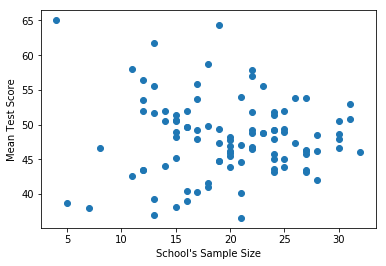

In [405]:
plt.scatter(count_by_school,mean_by_school)
plt.xlabel('School\'s Sample Size')
plt.ylabel('Mean Test Score')
plt.show()

We observe that the schools with fewer student data have higher variance
##### MCMC

Let us fit a normal hierarchical model to Mathtest dataset using Gibbs
Priors for unknown parameters are:
$$
\begin{aligned}\left(y_{i} | \theta_{i}, \sigma^{2}\right) & \sim N\left(\theta_{i}, \sigma^{2}\right) \\\left(\theta_{i} | \mu, \sigma^{2}, \tau^{2}\right) & \sim N\left(\mu, \sigma^{2} \tau^{2}\right) \\ \mu & \sim I_{\mathbb{R}}(\mu), \text { a flat prior} \\ \tau^{2} & \sim I_{\mathbb{R}^{+}}\left(\tau^{2}\right), \text { a flat prior} \\ \sigma^{2} & \sim\left(\frac{1}{\sigma^{2}}\right) I_{\mathbb{R}^{+}}\left(\sigma^{2}\right), \text { Jeffreys prior } \end{aligned}
$$

$$
\begin{aligned}\left(\theta_{i} | y, \mu, \sigma^{2}, \tau^{2}\right) & \sim N\left(m^{*}, v^{*}\right) \\ & \text { with } \\ v^{*} &=\left[\frac{n_{i}}{\sigma^{2}}+\frac{1}{\sigma^{2} \tau^{2}}\right]^{-1}=\left[\frac{n_{i} \tau^{2}+1}{\sigma^{2} \tau^{2}}\right]^{-1}=\sigma^{2}\left[\frac{\tau^{2}}{n_{i} \tau^{2}+1}\right] \\ m^{*} &=v^{*}\left[\left(\frac{n_{i}}{\sigma^{2}}\right) \overline{y}_{i}+\left(\frac{1}{\sigma^{2} \tau^{2}}\right) \mu\right] \end{aligned}
$$
$$
\begin{aligned}\left(\mu | \theta, y, \sigma^{2}, \tau^{2}\right) \sim N\left(\overline{\theta}_{i}, \frac{\sigma^{2} \tau^{2}}{p}\right)\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\end{aligned}
$$
$$
 \; \;\; \; \;\; \; \;\; \; \;\;\left(\sigma^{2} | \theta, y, \mu, \tau^{2}\right) \sim I G\left(\frac{(n+p)}{2},\left\{\frac{1}{2} \sum_{i=1}^{p} \sum_{j=1}^{n_{i}}\left(y_{i j}-\theta_{i}\right)^{2}+\frac{1}{2 \tau^{2}} \sum_{i=1}^{p}\left(\theta_{i}-\mu\right)^{2}\right\}\right)
$$
$$
\left(\tau^{2} | \theta, y, \mu, \sigma^{2}\right) \sim I G\left(\frac{p}{2}-1, \frac{1}{2 \sigma^{2}} \sum_{i=1}^{p}\left(\theta_{i}-\mu\right)^{2}\right)\; \;\; \; \;\; \; \;\; \; \;\;\; \;\; \; \;\; \; \;\; \; \;\;\; \;\; \; \;\;
$$

Initiations for Monte Carlo Sims

In [406]:
iterations = 10000
sigmasq = np.zeros(iterations+1)
tausq = np.zeros(iterations+1)
mu = np.zeros(iterations+1)
theta = np.zeros((school_group_count, iterations+1))
sigmasq[0] = 1
tausq[0] = 1
mu[0] = aggregate_mean
theta[:,0] = mean_by_school.values[:,0]

In [407]:
for i in range(iterations):
    vstar = (sigmasq[i]*tausq[i]) / (count_by_school.values*tausq[i] + 1)
    mstar = vstar * ( count_by_school.values*mean_by_school.values/sigmasq[i] + mu[i]/(sigmasq[i]*tausq[i]) )
    theta[:,i+1] = np.random.normal(mstar,vstar)[:,0]
    mu[i+1] = np.random.normal(np.mean(theta[:,i+1]),sigmasq[i]*tausq[i]/school_group_count)
    schoolindexes = math_df.values[:,0].astype(int) - 1
    sum1 = np.sum( np.square((math_df.values[:,1]-theta[schoolindexes,i+1])))
    sum2 = np.sum( np.square(theta[:,i+1] - mu[i+1]) )
    sigmasq[i+1] = 1 / np.random.gamma( (total_numof_data+school_group_count)/2 , 1/(0.5*(sum1 + sum2/tausq[i])) )
    tausq[i+1] = 1 / np.random.gamma( 0.5*school_group_count-1 , 1/(0.5*(sum2/sigmasq[i+1])) )

In [408]:
#Burn Beginning Observations
burn = 1000
theta = theta[:,burn:-1]
mu = mu[burn:-1]
sigmasq = sigmasq[burn:-1]
tausq = tausq[burn:-1]
#Thin the data
thin = 2
slicedindex = range(0,len(tausq),thin)
theta = theta[:,slicedindex]
mu = mu[slicedindex]
sigmasq = sigmasq[slicedindex]
tausq = tausq[slicedindex]

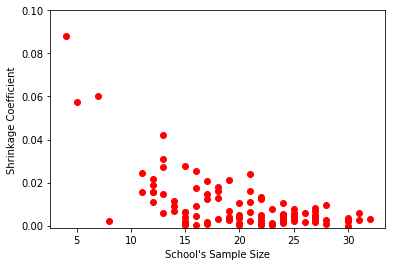

In [440]:
post_mean = np.mean(theta,1)
ki = abs((post_mean-mean_by_school.values[:,0])/mean_by_school.values[:,0])
x_ki = list(range(1,len(ki)+1))
plt.scatter(count_by_school.values[:,0],ki,c='r')
#plt.scatter([1],[5])
axes = plt.gca()
axes.set_ylim([-0.001,0.1])
plt.xlabel('School\'s Sample Size')
plt.ylabel('Shrinkage Coefficient')
plt.show()

### Price Elasticity of Demand